<a href="https://colab.research.google.com/github/Doppler-67/sentiment_analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Цель проекта:**

Нужно построить модель, которая будет определять токсичность текста.

**Описание данных:**

В качестве данных был взят корпус русскоязычных твитов RuTweetCorp.

⭕ Более подробная информация находится в README файле.

# **Importing libraries**

In [1]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import nltk
import re
import transformers
import matplotlib.pyplot as plt

from tqdm import notebook

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from pymystem3 import Mystem 

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
sns.set()

# **Data understanding**

In [4]:
col_names = ['id', 'tdate', 'tmane', 'text', 'toxic', 'trep', 'trtw', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount']

In [5]:
pos_data = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/positive.csv', sep=';', header=None, names=col_names)
neg_data = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/negative.csv', sep=';', header=None, names=col_names)

In [6]:
pos_data.head()

,id,tdate,tmane,text,toxic,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [7]:
neg_data.head()

,id,tdate,tmane,text,toxic,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


Данные загружены и изучены, теперь приступим к предобработке.

# **Data preparation**

In [8]:
neg_data['toxic'] = 0

Соединим все один датасет.

In [9]:
data = pd.concat([pos_data, neg_data])

In [10]:
data.head()

,id,tdate,tmane,text,toxic,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


Отбросим ненужные колонки.

In [11]:
data = data[['text', 'toxic']]

In [12]:
data['toxic'] = data['toxic'].astype(bool)

Теперь очистим корпус от лишних символов при помощи регулярных выражений.

In [13]:
def clear_text(text):
    t = re.sub(r'[^а-яА-ЯёЁ ]', ' ', text)
    t = ' '.join(t.split())
    return t

In [14]:
data['clear_text'] = data['text'].apply(clear_text)

Проверим есть ли предложения, которые вообще не содержат символов, после обработки регуляркой.

In [15]:
data[data['clear_text'] == '']

,text,toxic,clear_text
9374,RT @_Batonchik_: @cekc_tyt @aabdullaeva1 @chem...,False,
21396,RT @SolarEclipse57: @girl_turner666 @SCOOB_JOE...,False,
47515,RT @unixOS_ctts: @Mo_OnMery @SimplyShot @_Shav...,False,
62937,"RT @puteribunga10: ""@kinantinatya: :""""""""""""""""""""...",False,


Удалим их.

In [16]:
data = data[data['clear_text'] != '']

Проверим на наличие дубликатов.

In [17]:
data.duplicated().sum()

9394

Удалим дубликаты.

In [18]:
data = data.drop_duplicates().reset_index(drop=True)

Уберем верхний регистр.

In [19]:
data['clear_text'] = data['clear_text'].str.lower() 

Перемешаем данные.

In [20]:
data = data.sample(frac=1, random_state=67).reset_index(drop=True)

In [21]:
data.head()

,text,toxic,clear_text
0,Нормальный парень никогда не станет унижать бы...,True,нормальный парень никогда не станет унижать бы...
1,"нихачу в универ обратно, хочу быть эльфиком(",False,нихачу в универ обратно хочу быть эльфиком
2,@EvgenyFeldman с ним уже пару месяцев такое. н...,False,с ним уже пару месяцев такое не обращай внимание
3,"@elenabodya заебись, люблю @elenabodya , сэко...",True,заебись люблю сэкономил к на куртке
4,"лазила по ВК и наткнулась на девочку с ником ""...",True,лазила по вк и наткнулась на девочку с ником к...


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217436 entries, 0 to 217435
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        217436 non-null  object
 1   toxic       217436 non-null  bool  
 2   clear_text  217436 non-null  object
dtypes: bool(1), object(2)
memory usage: 3.5+ MB


Предобработку завершили, теперь приступим к EDA.

# **EDA**

Изучим кол-во символов и слов в текстах.

In [23]:
data['symbols'] = data['clear_text'].apply(len)
data['tokens'] = data['clear_text'].str.split().apply(len)


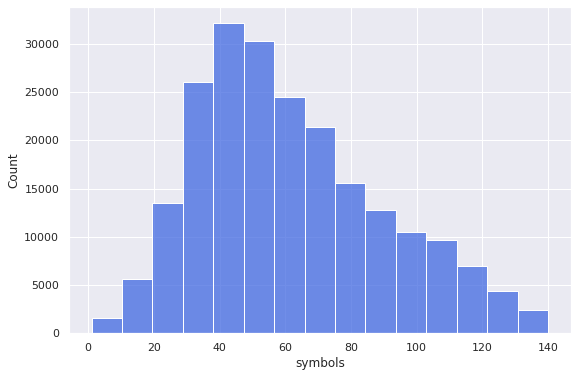

In [24]:
plt.figure(figsize=(9, 6))
sns.histplot(x=data['symbols'], color='royalblue', bins=15)
plt.show()

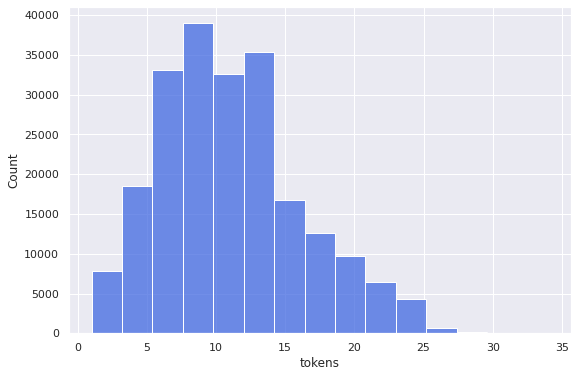

In [25]:
plt.figure(figsize=(9, 6))
sns.histplot(x=data['tokens'], color='royalblue', bins=15)
plt.show()

Изучим таргет.

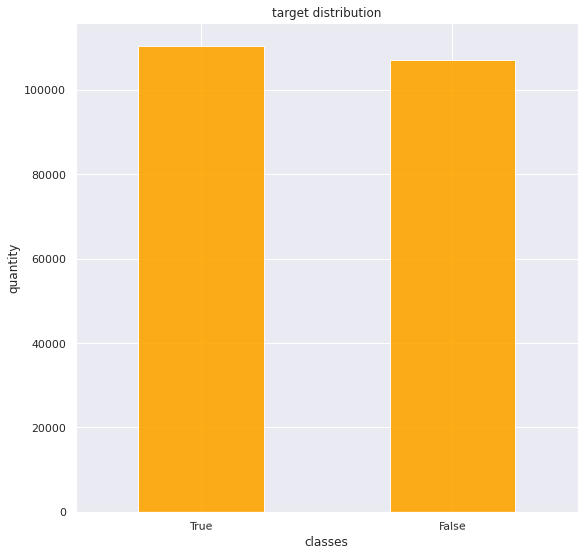

In [26]:
data['toxic'].value_counts().plot(kind='bar', title='target distribution', xlabel='classes', 
                                     ylabel='quantity', rot=1, color='orange', alpha =0.9, figsize=(9,9))
plt.show()

в таргете классы сбалансированы.

Удалим строки в которых всего одно слово, так как такие предложения слишком не информативны.

In [27]:
data = data[data['tokens'] > 1]

Удалим ненужные колонки.

In [28]:
data = data.drop(['symbols', 'tokens'], axis=1)

EDA завершили.

Попробуем два подхода:
1. TF-IDF + logreg.
2. эмбеддинги, сгенерированные с помощью ruBERT + logreg.

# **TF-IDF**

Лемматизируем текст.

In [29]:
m = Mystem()

In [30]:
def lemmatize_text(text):
    tokens = m.lemmatize(text.lower())
    tokens = [token for token in tokens if token != '\n']
    text = " ".join(tokens)
    
    return text

In [31]:
data['lemm_text'] = data['clear_text'].apply(lemmatize_text)

In [32]:
data.head()

,text,toxic,clear_text,lemm_text
0,Нормальный парень никогда не станет унижать бы...,True,нормальный парень никогда не станет унижать бы...,нормальный парень никогда не становить...
1,"нихачу в универ обратно, хочу быть эльфиком(",False,нихачу в универ обратно хочу быть эльфиком,нихач в универ обратно хотеть быть ...
2,@EvgenyFeldman с ним уже пару месяцев такое. н...,False,с ним уже пару месяцев такое не обращай внимание,с он уже пара месяц такой не обр...
3,"@elenabodya заебись, люблю @elenabodya , сэко...",True,заебись люблю сэкономил к на куртке,заебись любить сэкономить к на куртка
4,"лазила по ВК и наткнулась на девочку с ником ""...",True,лазила по вк и наткнулась на девочку с ником к...,лазить по вк и наткнуться на девоч...


In [33]:
nltk.download('stopwords')
stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
x_train, x_test, y_train, y_test = train_test_split(data['lemm_text'], data['toxic'], train_size=0.8, random_state=67)

In [35]:
train_corpus = x_train.values.astype('U')
test_corpus = x_test.values.astype('U')

In [36]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [37]:
train_tf_idf = count_tf_idf.fit_transform(train_corpus)
test_tf_idf = count_tf_idf.transform(test_corpus)

In [38]:
train_tf_idf.shape, test_tf_idf.shape

((173106, 81336), (43277, 81336))

In [39]:
model = LogisticRegression(max_iter=10000, random_state=67)

In [40]:
scores = cross_val_score(model, train_tf_idf, y_train, cv=5, scoring='roc_auc')
print(scores)
print('avg auc-roc:', sum(scores) / len(scores))

[0.78396184 0.78755216 0.78646815 0.78502709 0.78641283]
avg auc-roc: 0.7858844132232634


Подберем гиперпараметры.

In [41]:
log_reg_params = {
    'C': [10 ** -2, 10 ** -1, 1, 10, 10 ** 2], 
    'solver' : ['lbfgs', 'liblinear']
    }

In [42]:
clf = GridSearchCV(model, log_reg_params, scoring='roc_auc')
clf.fit(train_tf_idf, y_train)
clf.best_params_

{'C': 1, 'solver': 'lbfgs'}

In [43]:
model = clf.best_estimator_
model.fit(train_tf_idf, y_train)

LogisticRegression(C=1, max_iter=10000, random_state=67)

Напишем фунцию для удобного построения графика AUC-ROC.

In [44]:
def display_auc_roc(model, x, y):
  probs = model.predict_proba(x)
  preds = probs[:,1]
  fpr, tpr, threshold = roc_curve(y, preds)
  roc_auc = auc(fpr, tpr)

  plt.title('ROC')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

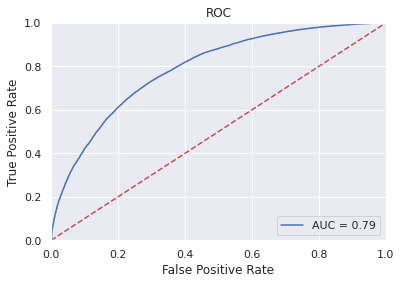

In [45]:
display_auc_roc(model, test_tf_idf, y_test)

Первый подход показал хороший результат. Приступим ко второму.

# **ruBERT**

Сохраним обработанный датасет и сгенерируем эмбеддинги в файле 
```embeddings_generation.ipynb```




In [46]:
data.to_csv('prepared_data.csv', index=False)

Эмбеддинги были сгенерированы по батчам. Загрузим их.

In [47]:
emb_0 = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/emb_0.csv')
emb_1 = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/emb_1.csv')
emb_2 = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/emb_2.csv')
emb_3 = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/emb_3.csv')
emb_4 = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/emb_4.csv')
emb_5 = pd.read_csv('/content/drive/MyDrive/sentiment_analysis/emb_5.csv')

Соеденим все эмбеддинги.

In [48]:
embeddings = [emb_0, emb_1, emb_2, emb_3, emb_4, emb_5]

In [49]:
embeddings = np.vstack(embeddings)

Отделим таргет.

In [50]:
features = embeddings[:, :-1]
target = embeddings[:, -1].astype(bool)

In [51]:
x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state=67)

In [52]:
model = LogisticRegression(max_iter=10000, random_state=67)

In [53]:
scores = cross_val_score(model, x_train, y_train, cv=5, scoring='roc_auc')
print(scores)
print('avg auc-roc:', sum(scores) / len(scores))

[0.74141079 0.738545   0.73568163 0.74604227 0.73898087]
avg auc-roc: 0.7401321100598595


Подберем гиперпараметры.

In [54]:
clf = GridSearchCV(model, log_reg_params, scoring='roc_auc')
clf.fit(x_train, y_train)
clf.best_params_

{'C': 0.1, 'solver': 'liblinear'}

In [55]:
model = clf.best_estimator_
model.fit(x_train, y_train)

LogisticRegression(C=0.1, max_iter=10000, random_state=67, solver='liblinear')

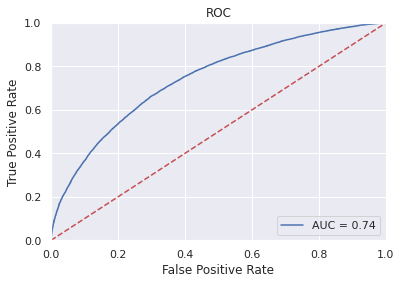

In [56]:
display_auc_roc(model, x_test, y_test)

Результат неплохой, но TF-IDF справился лучше.

# **Results**

**В данном проекте было протестировано два различных подхода и TF-IDF показал себя лучше, как с точки зрения результата, так и с точки зрения времени выполнения. Удалось достичь 0.79 по метрике AUC-ROC.**